<a href="https://colab.research.google.com/github/henrywang1/AI-practice/blob/master/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from pylab import rcParams
import seaborn as sns

import pandas as pd

csv_path = "/content/drive/My Drive/ML/hw2_data.csv"
df = pd.read_csv(csv_path)


## **(i) Data exploration**

### Answer: The **primary_strength** is categorical data, and all other attributes are numerical data.


In [ ]:
df.head()

,name,stamina,attack_value,defense_value,capture_rate,flee_rate,spawn_chance,primary_strength,combat_point
0,Bulbasaur,90,126,126,0.16,0.10,69.0,Grass,1079
1,Ivysaur,120,156,158,0.08,0.07,4.2,Grass,1643
2,Venusaur,160,198,200,0.04,0.05,1.7,Grass,2598
3,Charmander,78,128,108,0.16,0.10,25.3,Fire,962
4,Charmeleon,116,160,140,0.08,0.07,1.2,Fire,1568


## **(ii) Data exploration**

### Answer: The **attak_value** is the most predictive one, and its sample Pearson’s correlation coefficient is **0.91**.



In [ ]:
def pearsonr(x, y):
    x = x.to_numpy().astype('float')
    y = y.to_numpy().astype('float')
    x_xm, y_ym = x-x.mean(), y-y.mean()
    return (x_xm * y_ym).sum() / np.sqrt( np.sum(x_xm*x_xm) * np.sum(y_ym*y_ym))

num_attributes = [col for col in df.columns if not col in ["name", "primary_strength", "combat_point"]]
for attr in num_attributes:
    print(attr, "{:.2f}".format(pearsonr(df[attr], df["combat_point"])))


stamina 0.58
attack_value 0.91
defense_value 0.83
capture_rate -0.74
flee_rate -0.41
spawn_chance -0.42


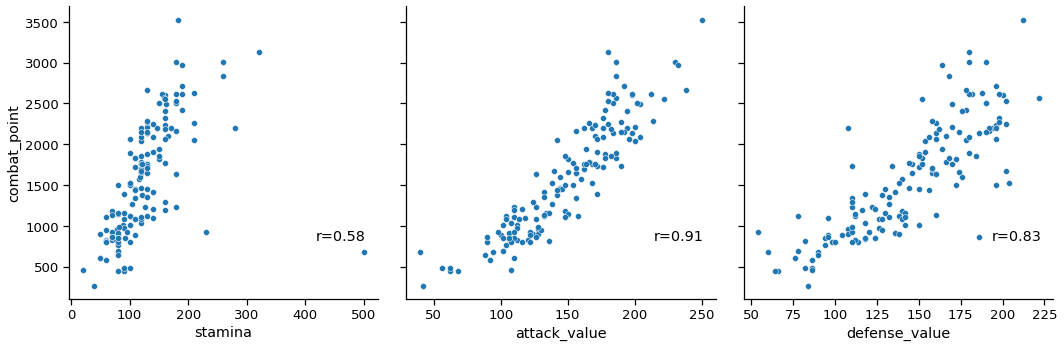

In [ ]:
# Reference: https://stackoverflow.com/questions/43251021/show-two-correlation-coefficients-on-pairgrid-plot-with-hue-categorical-variabl
def corr_func(x, y, **kws):
    r = pearsonr(x, y)
    ax = plt.gca()
    n = len([c for c in ax.get_children() if isinstance(c, matplotlib.text.Annotation)])
    pos = (.8, .2)
    ax.annotate("r={:.2f}".format(r), xy=pos, xycoords=ax.transAxes)

with sns.plotting_context("notebook", font_scale=1.2):
    g = sns.PairGrid(data=df, x_vars=num_attributes[:3], y_vars=["combat_point"], height=5)
    g.map(corr_func)
    g.map(sns.scatterplot)
    plt.plot()

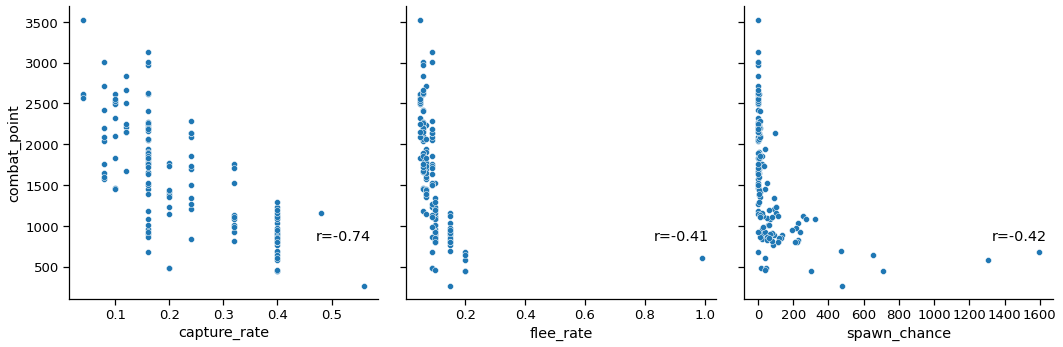

In [ ]:







with sns.plotting_context("notebook", font_scale=1.2):
    g = sns.PairGrid(data=df, x_vars=num_attributes[3:], y_vars=["combat_point"], height=5)
    g.map(corr_func)
    g.map(sns.scatterplot)
    plt.plot()



## **(iii) Data exploration**

### Answer: 
All the correlation coefficients are shown on the figure.

The **attack_value** and the **defense_value** are the most correlated, where the correlation coefficient is 0.74. 

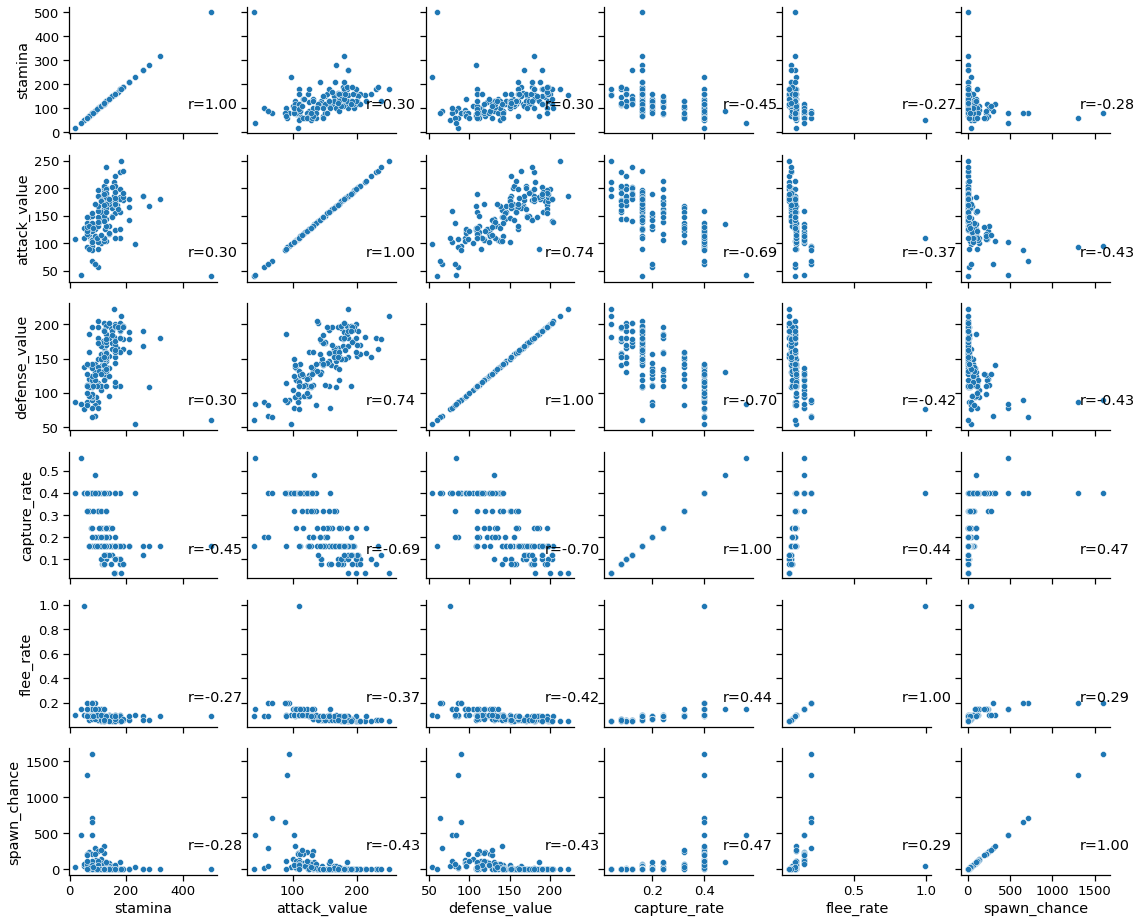

In [ ]:
with sns.plotting_context("notebook", font_scale=1.2):
    g = sns.PairGrid(data=df, x_vars=num_attributes, y_vars=num_attributes, height=2.2, aspect=1.2, layout_pad=0.6)
    g.map(corr_func)
    g.map(sns.scatterplot)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## **(iv) Pre-processing of categorical variables**

### The implementation of one_hot_encoding is applied on the dataframe directly before we creating the numpy array, and the number of counts per category is printed as below.

In [ ]:
def one_hot_encoding(df):
    cats = df["primary_strength"].unique()
    for cat in cats:
        df[cat] = (df["primary_strength"] == cat).astype(float)

def prepareData(df):
    one_hot_encoding(df)
    # Prepare numpy array
    df = df.drop("primary_strength", 1)
    df = df.drop("name", 1)

    # Randomly shuffle data
    df = df.sample(frac = 1)
    y = df["combat_point"].astype(float)
    y = np.array(y)
    df = df.drop("combat_point", 1)
    df.insert(loc=0, column='bias', value=1)
    X = df.to_numpy().astype(float)
    return df, X, y

df = pd.read_csv(csv_path)
print(pd.DataFrame(df["primary_strength"].value_counts()))
df, X, y = prepareData(df)
df.head()

          primary_strength
Water                   28
Normal                  22
Poison                  14
Grass                   12
Bug                     12
Fire                    11
Rock                     9
Ground                   8
Electric                 8
Fighting                 7
Psychic                  6
Dragon                   3
Ghost                    3
Fairy                    2
Ice                      1


,bias,stamina,attack_value,defense_value,capture_rate,flee_rate,spawn_chance,Grass,Fire,Water,Bug,Normal,Poison,Electric,Ground,Fairy,Fighting,Psychic,Rock,Ghost,Ice,Dragon
31,1,92,110,94,0.40,0.15,131.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139,1,60,148,142,0.32,0.09,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
68,1,100,158,78,0.40,0.15,115.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57,1,110,156,110,0.24,0.10,92.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,1,122,142,128,0.20,0.07,8.3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br>
<br>
<br>

## **(v) Predicting combat points**

### Answer: 
*   ### The number of parameters is: 22
*   ### The RSS is implemented as "np.square(y_test-y_pred).sum()"
*   ### The square root of RSS of each fold and the average of all sqrt(RSS) is shown below

In [ ]:
from sklearn.metrics import mean_squared_error

def normalize(X, mean_x_train, std_x_train):
    return (X - mean_x_train) / (std_x_train + 1e-6)

class LinearRegression(object):
    def __init__(self):
        self.w_star = None
        
    def fit(self, x, y, lmda=0):
        self.w_star = np.linalg.pinv(x.T@(x) + np.eye(x.shape[1])*lmda)@(x.T)@(y)


    def pred(self, x):
        return x.dot(self.w_star.reshape(-1, 1)).reshape(-1)

    def __repr__(self):
        return "LinearRegression with {} parameters".format(self.w_star.reshape(-1).shape[0])

    def __str__(self):
        return "LinearRegression with {} parameters".format(self.w_star.reshape(-1).shape[0])

class Kfold(object):
    def __init__(self, k, x_length):
        self.k = k
        self.size = int(x_length/k)
        self.text_index = []
        for i in np.arange(k):
            size = self.size
            if i == 0:
                size += x_length % k
            self.text_index.append(np.array(i).repeat(size))
        self.text_index = np.concatenate(self.text_index)

    def fold(self, X, y, i):
        indices = np.arange(len(X))
        test_mask = self.text_index == i
        test_index = indices[test_mask]
        train_index = indices[np.logical_not(test_mask)]
        return X[train_index], y[train_index], X[test_index], y[test_index]

    def kfold_reg(self, X, y, reg, lmda=0, verbose=True):
        average = []
        for i in range(self.k):
            X_train, y_train, X_test, y_test = self.fold(X, y, i)
            reg.fit(X_train, y_train, lmda)
            
            y_pred = reg.pred(X_test)
            if i == 0 and lmda == 0 and verbose:
                print(reg)

            RSS = np.sqrt(np.square(y_test-y_pred).sum())
            if lmda == 0 and verbose:
                print("Fold = {} sqrt(RSS)={}".format(i+1, RSS))
            average.append(RSS)
        avg_rss = sum(average)/len(average)
        if verbose:
            print("k={}, lamda={}, the average of square root of RSS error is {:.8f}".format(self.k, lmda, avg_rss))

        return avg_rss.round(2)

    def kfold_cls(self, X, y, clf, lmda=0, verbose=True):
        average = []
        for i in range(self.k):
            X_train, y_train, X_test, y_test = self.fold(X, y, i)
            mean_x_train = X_train.mean(axis=0)
            std_x_train = X_train.std(axis=0)
            X_train = normalize(X_train, mean_x_train, std_x_train)
            X_test =  normalize(X_test, mean_x_train, std_x_train)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
            ACC = (y_pred == y_test).mean()
            average.append(ACC)
        avg_accuracy = sum(average)/len(average)
        if verbose:
            print("k={}, lamda={}, the average accuracy is {:.8f}".format(self.k, lmda, avg_accuracy))
        
        return avg_accuracy

df = pd.read_csv(csv_path)
df, X, y = prepareData(df)
reg = LinearRegression()
rss = Kfold(5, len(X)).kfold_reg(X, y, reg)

LinearRegression with 22 parameters
Fold = 1 sqrt(RSS)=513.7970156690413
Fold = 2 sqrt(RSS)=840.3893892524081
Fold = 3 sqrt(RSS)=740.2257329980325
Fold = 4 sqrt(RSS)=689.8510155393191
Fold = 5 sqrt(RSS)=1547.6034956395113
k=5, lamda=0, the average of square root of RSS error is 866.37332982


## **(vi) Predicting combat points with regularization**

### Answer: The best $\lambda$ is 0.025, and the details are shown bewlow.

In [ ]:
import math

best_rss = math.inf
best_lambda = 0
for lmda in [0, 0.001, 0.0025, 0.005, 0.075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 10]:
    reg = LinearRegression()
    rss =  Kfold(5, len(X)).kfold_reg(X, y, reg, lmda)
    if (rss < best_rss):
        best_rss = rss
        best_lambda = lmda

print("The best sqrt(rss) is {}".format(best_rss))
print("The best lambda is {}".format(best_lambda))

LinearRegression with 22 parameters
Fold = 1 sqrt(RSS)=513.7970156690413
Fold = 2 sqrt(RSS)=840.3893892524081
Fold = 3 sqrt(RSS)=740.2257329980325
Fold = 4 sqrt(RSS)=689.8510155393191
Fold = 5 sqrt(RSS)=1547.6034956395113
k=5, lamda=0, the average of square root of RSS error is 866.37332982
k=5, lamda=0.001, the average of square root of RSS error is 863.49970865
k=5, lamda=0.0025, the average of square root of RSS error is 859.86682372
k=5, lamda=0.005, the average of square root of RSS error is 855.23175750
k=5, lamda=0.075, the average of square root of RSS error is 847.70164183
k=5, lamda=0.01, the average of square root of RSS error is 849.51237720
k=5, lamda=0.025, the average of square root of RSS error is 844.44708311
k=5, lamda=0.05, the average of square root of RSS error is 845.44145761
k=5, lamda=0.075, the average of square root of RSS error is 847.70164183
k=5, lamda=0.1, the average of square root of RSS error is 849.76026620
k=5, lamda=0.25, the average of square root o

## **(vii)**
### From the data exploration in (ii), we know that stamina	attack, and defense are mostly related to combat_points, so I try the feature combination by using [bias, stamina, attack, defencse] plus random n features.

### The best sqrt(RSS) is 798.88, when using ['stamina', 'attack_value', 'defense_value', 'flee_rate', 'spawn_chance', 'Water', 'Bug', 'Poison', 'Ground', 'Fairy', 'Psychic', 'Rock', 'Ghost']

In [ ]:
from tqdm.notebook import tqdm
from itertools import combinations
import random

total_features = X.shape[1]
best_rss = math.inf
best_comb = 0

for n in tqdm(range(1, total_features-2)):
    combs = combinations(range(4, total_features), n)
    combs = list(combs)
    if len(combs) > 10000:
        combs = random.choices(combs, k=10000)

    for comb in combs:
        comb = list(comb)
        comb = [0, 1, 2, 3] + comb # [bias, stamina, attack, defencse] + [random n features]
        reg = LinearRegression()
        rss = Kfold(5, len(X)).kfold_reg(X[:, comb], y, reg, best_lambda, verbose=False)
        if rss < best_rss:
            best_rss = rss
            best_comb = comb

print("The best sqrt(rss) is {}".format(best_rss))
print("The best combination is {}".format(best_comb))


The best sqrt(rss) is 798.88
The best combination is [0, 1, 2, 3, 5, 6, 9, 10, 12, 14, 15, 17, 18, 19]


In [ ]:
print(list(df.iloc[:, list(best_comb)].columns))

['bias', 'stamina', 'attack_value', 'defense_value', 'flee_rate', 'spawn_chance', 'Water', 'Bug', 'Poison', 'Ground', 'Fairy', 'Psychic', 'Rock', 'Ghost']


## **(viii)**
### The accuracy of the logistic regression model is 0.933.

In [ ]:
from sklearn.linear_model import LogisticRegression

df = pd.read_csv(csv_path)
df, X, y = prepareData(df)
y_cls = (y > y.mean()).astype(int)
# take the first fold as train test split
X_train, y_train, X_test, y_test = Kfold(5, len(X)).fold(X[:, 1:], y_cls, 0)

# We should assume X_test is unknown, so I normalize data only using X_train.
mean_x_train = X_train.mean(axis=0)
std_x_train = X_train.std(axis=0)
X_train_norm = normalize(X_train, mean_x_train, std_x_train)
X_test_norm =  normalize(X_test, mean_x_train, std_x_train)

clf = LogisticRegression(random_state=0, max_iter=10000, penalty='none')
clf.fit(X_train_norm, y_train)
y_pred = clf.predict(X_test_norm)
ACC = (y_pred == y_test).mean()
print("The accuracy is {:.5f}.".format(ACC))

The accuracy is 0.93333.


<br>

## **(ix)**
### The best $\lambda$ is 0.25, and the finaly accuracy is 0.967.

In [ ]:
best_acc = 0
best_lambda = 0
for lmda in [0, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]:
    if lmda == 0:
        clf = LogisticRegression(random_state=0, max_iter=10000, penalty='none')
    else: # C: inverse of regularization strength
        clf = LogisticRegression(random_state=0, max_iter=10000, C=1/lmda)
    # The normalization is implemented in kfold_cls
    acc = Kfold(5, len(X_train)).kfold_cls(X_train, y_train, clf, lmda)
    if (acc > best_acc):
        best_acc = acc
        best_lambda = lmda

print("The best accuracy is {:.5f}".format(best_acc))
print("The best lambda is {}".format(best_lambda))

if best_lambda == 0:
    clf = LogisticRegression(random_state=0, max_iter=1000, penalty='none')
else: # C: inverse of regularization strength
    clf = LogisticRegression(random_state=0, max_iter=1000, C=1/best_lambda)

clf.fit(X_train_norm, y_train)
y_pred = clf.predict(X_test_norm)
ACC = (y_pred == y_test).mean() 

print(clf)
print("The accuracy is {:.5f}.".format(ACC))


k=5, lamda=0, the average accuracy is 0.95760870
k=5, lamda=0.001, the average accuracy is 0.94021739
k=5, lamda=0.0025, the average accuracy is 0.94021739
k=5, lamda=0.005, the average accuracy is 0.94021739
k=5, lamda=0.0075, the average accuracy is 0.94021739
k=5, lamda=0.01, the average accuracy is 0.94021739
k=5, lamda=0.025, the average accuracy is 0.95724638
k=5, lamda=0.05, the average accuracy is 0.95724638
k=5, lamda=0.075, the average accuracy is 0.95724638
k=5, lamda=0.1, the average accuracy is 0.95724638
k=5, lamda=0.25, the average accuracy is 0.96594203
k=5, lamda=0.5, the average accuracy is 0.96594203
k=5, lamda=0.75, the average accuracy is 0.96594203
k=5, lamda=1, the average accuracy is 0.96594203
The best accuracy is 0.96594
The best lambda is 0.25
LogisticRegression(C=4.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
      